In [ ]:
#import required libs
#np and pandas
import numpy as np
import pandas as pd
#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#read dataset and save it in a variable
dataset = pd.read_csv("clean_kaggle_data_2020.csv",low_memory=False)

In [ ]:
#drop the row of description
dataset = dataset.drop(0)

As mentioned in the description file, the columns that includes "Part" and "OTHER" represent for different selections of each question. This will help us change some Nan values which should not be dropped.

In [ ]:
#select specific column and fill
for i in dataset.columns:
  if "Part" in i or "OTHER" in i:
    dataset[i] = dataset[i].fillna("no select")

In [ ]:
dataset.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,...,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER,Q24_Encoded,Q24_buckets
1,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,Python,no select,no select,Visual Studio,no select,PyCharm,no select,no select,Sublime Text,no select,no select,no select,no select,no select,Colab Notebooks,no select,no select,no select,no select,no select,...,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,10.0,"100,000-124,999"
2,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,no select,no select,no select,no select,no select,Java,Javascript,no select,no select,Bash,no select,no select,no select,R,no select,no select,no select,Visual Studio Code (VSCode),no select,no select,Notepad++,Sublime Text,Vim / Emacs,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,...,no select,no select,no select,no select,no select,None,no select,no select,no select,no select,no select,no select,no select,None,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,None,no select,1.0,"10,000-19,999"
3,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,no select,SQL,no select,no select,no select,no select,no select,no select,Bash,no select,no select,no select,Python,no select,no select,no select,no select,PyCharm,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,...,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,11.0,"125,000-149,9991"
4,762,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,Python,no select,SQL,no select,no select,no select,no select,no select,no select,Bash,no select,no select,no select,Python,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",no select,no select,no select,PyCharm,no select,no select,Sublime Text,Vim / Emacs,no select,no select,no select,Kaggle Notebooks,Colab Notebooks,no select,no select,no select,no select,no select,...,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no select,no sel

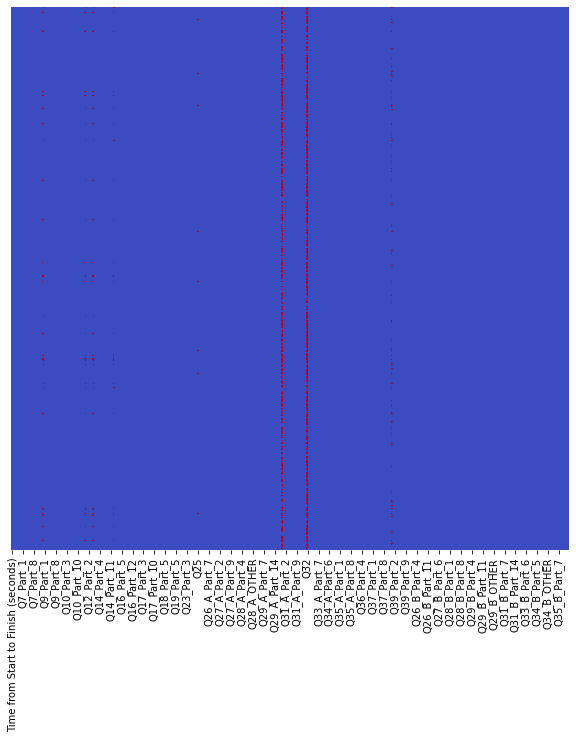

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(dataset.isnull(),cmap="coolwarm",yticklabels=False,cbar=False,ax=ax)

In [ ]:
dataset.isnull().sum().sort_values(ascending=False).head(10)

Q32             9231
Q30             7216
Q38             1253
Q11              561
Q15              561
Q13              561
Q8               561
Q25              159
Q26_A_Part_1       0
Q23_Part_5         0
dtype: int64

Let's investigate these question and try to figure out how to get rid of these nan values.

Q25: Approximately how much money have you (or your team) spent on machine learning and/or cloud computing services at home (or at work) in the past 5 years (approximate $USD)?


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


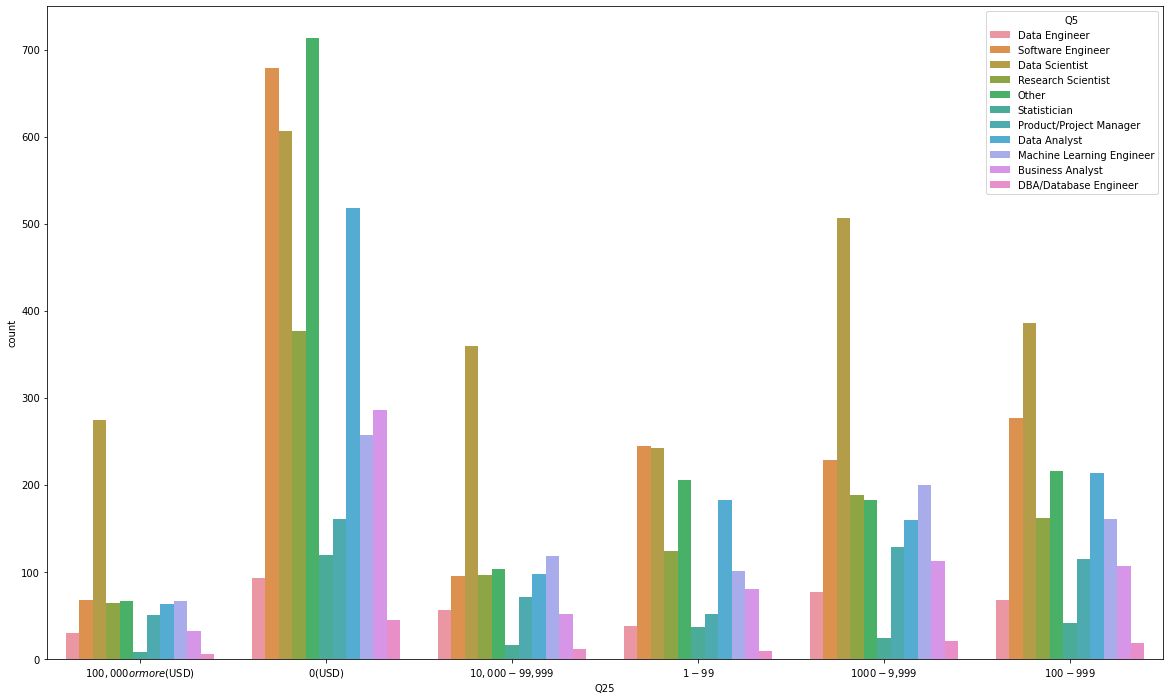

In [ ]:
plt.figure(figsize=(20, 12))
sns.countplot('Q25', hue = "Q5",data=dataset)

Most of people do not spend money on machine learning and/or cloud computing services. Addtionally, it does not have an obvious relationship with job titles. Therefore, it can be assume that Nan values can be replace by using 0(USD).

In [ ]:
#Fill Nan in Q25 column
dataset["Q25"] = dataset["Q25"].fillna(dataset["Q25"].unique()[1])

For Q8 Q11 Q13 and Q15, it is odd to have exact same amount of missing values.

In [ ]:
print(
    #test if these missing values are casued by same people#
((dataset["Q11"].isnull() == dataset["Q13"].isnull()) == False).sum(),
((dataset["Q11"].isnull() == dataset["Q15"].isnull()) == False).sum(),
((dataset["Q13"].isnull() == dataset["Q15"].isnull()) == False).sum())

0 0 0


Lets save these rows in another variable first and remove them from the orignal dataset.

In [ ]:
#save these rows with missing values
dataset_Q11_null = dataset[dataset["Q11"].isnull()]
#remove them from the dataset
dataset = dataset[dataset["Q11"].isnull()==False]

Q38:What is the primary tool that you use at work or school to analyze data? (Include text response) - Selected Choice

In [ ]:
dataset["Q38"].unique()

array(['Business intelligence software (Salesforce, Tableau, Spotfire, etc.)',
       'Basic statistical software (Microsoft Excel, Google Sheets, etc.)',
       'Local development environments (RStudio, JupyterLab, etc.)',
       'Cloud-based data software & APIs (AWS, GCP, Azure, etc.)',
       'Advanced statistical software (SPSS, SAS, etc.)', 'Other', nan],
      dtype=object)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


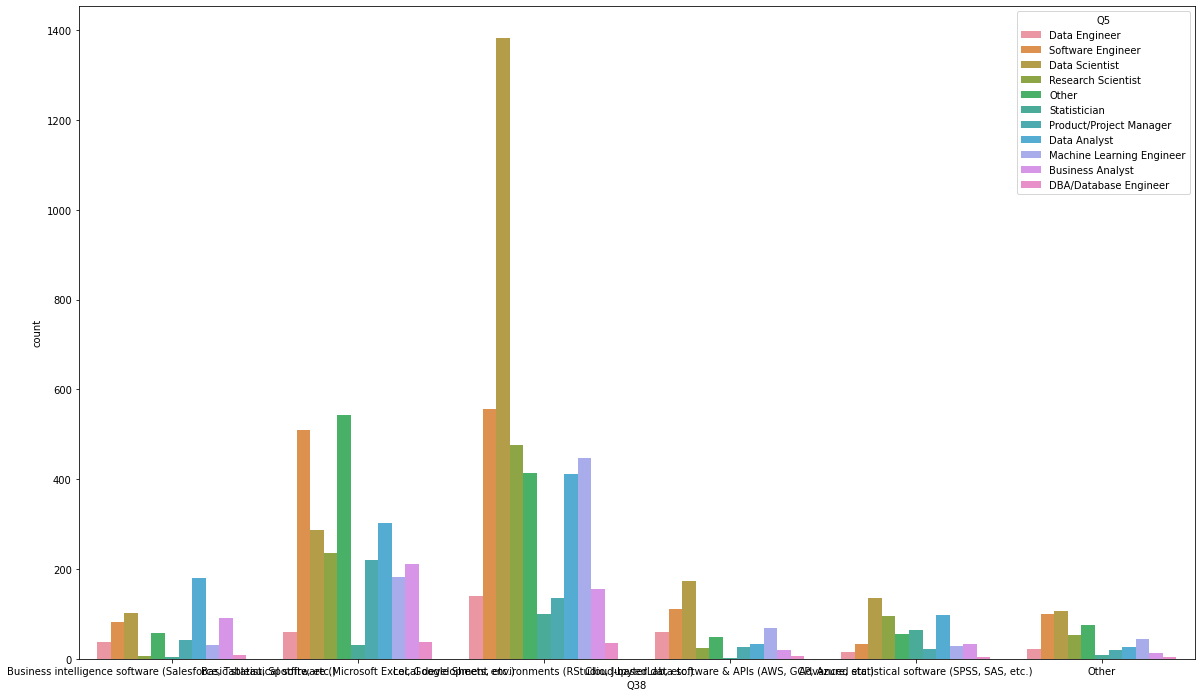

In [ ]:
plt.figure(figsize=(20, 12))
sns.countplot('Q38',hue="Q5",data=dataset)

It is clear that most of the data scientist and Machine Learning Enigneer use Local Develope Environment. Some of the Statisticians and Software Engineers use Basic Statistic tools. Let's investigate more on the job titles for those people who did not answer this question.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


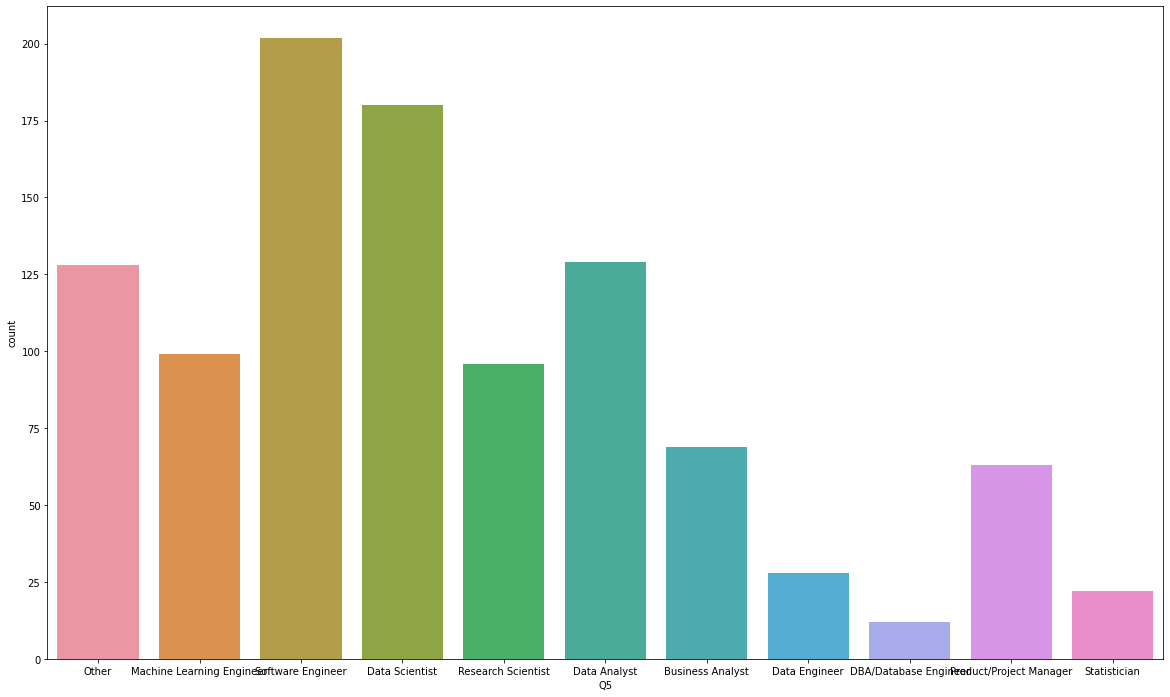

In [ ]:
temp = dataset[dataset["Q38"].isnull()]
plt.figure(figsize=(20, 12))
sns.countplot('Q5',data=temp)

In [ ]:
#define a function for replace
def get_q38(job):
  if job == "Data Scientist" or "Data Analyst" or "Software Engineer" or "Machine Learning Engineer" or "Data Engineer" or "DBA/Database Engineer":
    return 'Local development environments (RStudio, JupyterLab, etc.)'
  else:
    return 'Basic statistical software (Microsoft Excel, Google Sheets, etc.)'

In [ ]:
#replace the missing value by apply the function above
dataset.loc[dataset["Q38"].isnull(),"Q38"] = dataset[dataset["Q38"].isnull()].apply(lambda row: get_q38(row["Q5"]),axis=1)

Drop Q32 and Q30, the reason is that they all have too many missing values. If imputation is applied to these columns, it is difficult to know whether these column would have positivie impact or negative impact on the model.

In [ ]:
#drop useless column
dataset = dataset.drop([dataset.columns[0],"Q30","Q32"],axis=1)

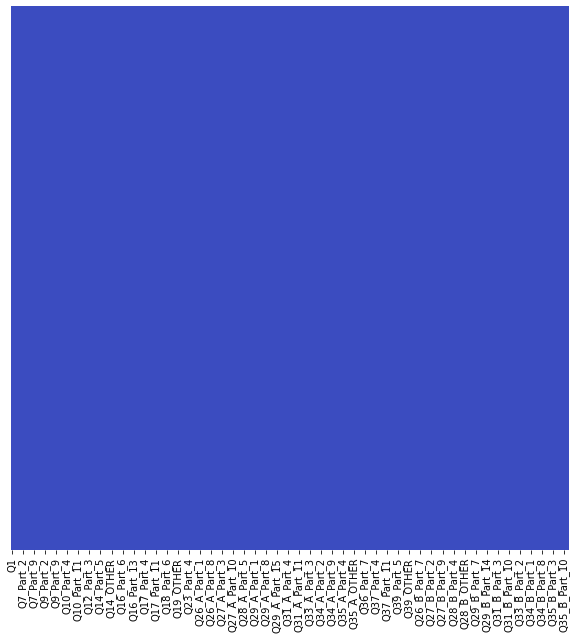

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(dataset.isnull(),cmap="coolwarm",yticklabels=False,cbar=False,ax=ax)

### Some Feature Selection before encode
The feature selection is conducted before encoding, because the number of features would be extremely high, and hence, it would be hard to measure the importance of each feature. Based on the question list, it can be seen that there are couple question which are asking about people's opinion in 2 years. Since the goal of the model is trying to classify the data points into different curent salary buckets, it can be assumed that those questions related to future have limited effect on the model. Therefore, Q26B to Q35B shall be dropped.

In [ ]:
dataset_cleaned = dataset

In [ ]:
for i in dataset_cleaned.columns:
  if "B_Part" in i or "B_OTHER" in i:
    dataset_cleaned = dataset_cleaned.drop(columns = [i]) 

more on feature selection
Drop Q24 Since it is in output

In [ ]:
dataset_cleaned.drop(columns=["Q24"],inplace=True)

In [ ]:
dataset_cleaned.shape

(10168, 254)

Encoding

In [ ]:
data_cleaned_input = dataset_cleaned.iloc[:,:-2]
data_cleaned_output = dataset_cleaned.iloc[:,-2]

In [ ]:
def encoding_df(df):
  for i in df.columns:
    df = pd.get_dummies(df,columns=[i],prefix=[i],drop_first=True)
  return df

In [ ]:
data_cleaned_input_encode = encoding_df(data_cleaned_input)

drop those columns includes "no select"

In [ ]:
for i in data_cleaned_input_encode.columns:
  if "no select" in i:
    data_cleaned_input_encode.drop(columns = [i],inplace= True) 

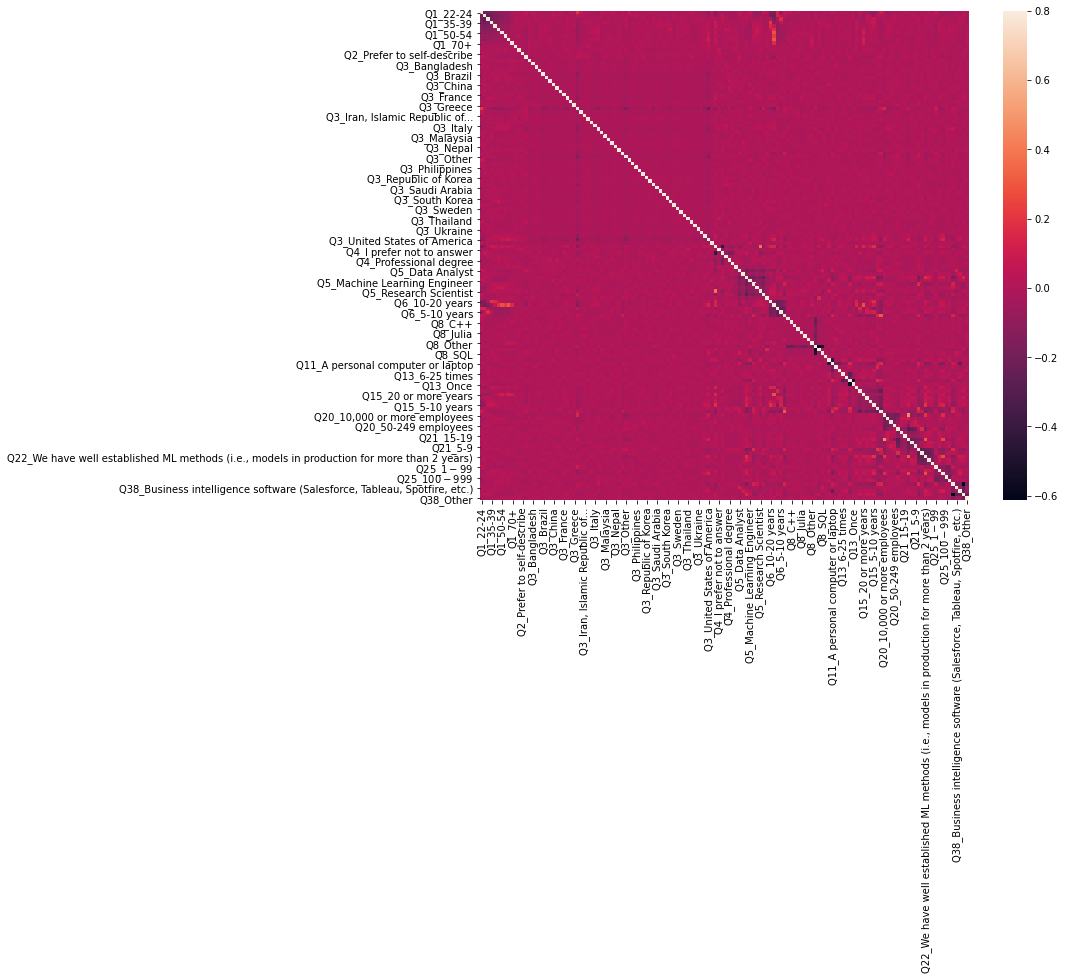

In [ ]:
#check heat map#
corr_mat = data_cleaned_input_encode.corr(method = 'kendall')
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.8, square=True, ax=ax)
plt.show()

Check if there are correlations higher than 0.8.

In [ ]:
columns = np.full((corr_mat.shape[0],), True, dtype=bool)
for i in range(corr_mat.shape[0]):
    for j in range(i+1, corr_mat.shape[0]):
        if corr_mat.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = data_cleaned_input_encode.columns[columns]
data_cleaned_input_encode = data_cleaned_input_encode[selected_columns]

In [ ]:
data_cleaned_input_encode.shape

(10168, 142)

Build Feature Importance Plot


In [ ]:
#Train Test Split
X = data_cleaned_input_encode
y = data_cleaned_output
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

In [ ]:
chi2_list, pval_list = chi2(X_train,y_train)

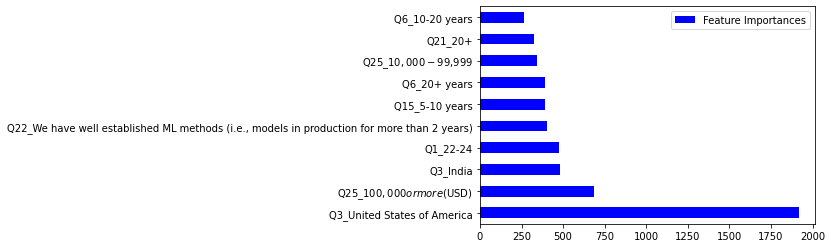

In [ ]:
pd.DataFrame(data = chi2_list,columns = ["Feature Importances"],index = X_train.columns).sort_values("Feature Importances", ascending = False)[:10].plot(kind = "barh", color = "blue")

Model Implementation

In [ ]:
import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

In [ ]:
#define a function for model#
#return a probability list#
def OLR(X,y,X_valid):#C,solver will be applied later#
  model = LogisticRegression()#C=C, solver=solver need to be here#
  #divide y class
  class_prob_list = []
  for i in range(15-1):
    divide_list = []
    for j in y:
      if j <=i:
        divide_list.append(0)
      else:
        divide_list.append(1)
    model.fit(X,divide_list)
    result = model.predict_proba(X_valid)
    if i == 0:
      class_prob_list.append(result[:,0])
    else:
      class_prob_list.append(result[:,0]-temp)
    temp = result[:,0]
  class_prob_list.append(result[:,1])
  return class_prob_list

In [ ]:
result_list = OLR(X_train,y_train,X_train)
predictions = np.array(result_list).argmax(axis=0).reshape(-1,1)

In [ ]:
final_train = predictions

In [ ]:
ACC = accuracy_score(y_train, predictions)
F1 = f1_score(y_train, predictions, average='weighted')

Cross Validation

In [ ]:
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve

In [ ]:
#This part is from Tutorial#
#Kfold in 10 splits#
kfold = KFold(n_splits=10)


accuracy = np.zeros(10)
np_idx = 0

for train_idx, valid_idx in kfold.split(X_train):
    X_kftrain, X_kfvalid = X_train.values[train_idx], X_train.values[valid_idx]
    y_kftrain, y_kfvalid = y_train.values[train_idx], y_train.values[valid_idx]
    result_list = OLR(X_kftrain,y_kftrain,X_kfvalid)
    predictions = np.array(result_list).argmax(axis=0).reshape(-1,1)
    #confusion_mat#

    ACC = accuracy_score(y_kfvalid, predictions)
    
    accuracy[np_idx] = ACC*100
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC*100,3)))   

print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

Fold 1: Accuracy: 42.135%
Fold 2: Accuracy: 41.854%
Fold 3: Accuracy: 42.135%
Fold 4: Accuracy: 44.101%
Fold 5: Accuracy: 45.225%
Fold 6: Accuracy: 41.011%
Fold 7: Accuracy: 40.449%
Fold 8: Accuracy: 43.179%
Fold 9: Accuracy: 45.71%
Fold 10: Accuracy: 43.319%
Average Score: 42.912%(1.638%)


Model Tuning

In [ ]:
def OLR(X,y,X_valid,C,solver):#C,solver will be applied#
  model = LogisticRegression(C=C,solver = solver)
  #divide y class
  class_prob_list = []
  for i in range(15-1):
    divide_list = []
    for j in y:
      if j <=i:
        divide_list.append(0)
      else:
        divide_list.append(1)
    model.fit(X,divide_list)
    result = model.predict_proba(X_valid)
    if i == 0:
      class_prob_list.append(result[:,0])
    else:
      class_prob_list.append(result[:,0]-temp)
    temp = result[:,0]
  class_prob_list.append(result[:,1])
  return class_prob_list

In [ ]:
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)###

#best_model = model###
best_params = {}
best_accuracy = 0
best_std = 0

for C in [0.001,0.01,0.05,0.1,0.5,1,5]:
    for solver in ['newton-cg','lbfgs','liblinear','sag']:
        
        accuracy = np.zeros(10)
        np_idx = 0
        
        for train_idx, valid_idx in kfold.split(X_train):
            X_kftrain, X_kfvalid = X_train.values[train_idx], X_train.values[valid_idx]
            y_kftrain, y_kfvalid = y_train.values[train_idx], y_train.values[valid_idx]
            result_list = OLR(X_kftrain,y_kftrain,X_kfvalid,C,solver)
            predictions = np.array(result_list).argmax(axis=0).reshape(-1,1)
            ACC = accuracy_score(y_kfvalid, predictions)

            accuracy[np_idx] = ACC*100
            np_idx += 1
        
        if np.mean(accuracy) > best_accuracy:
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 0.1, 'solver': 'liblinear'}
Best Score: 43.319%(1.95%)

The optimal log model uses C=0.1, and a liblinear solver, and has a cross validation score of 43.319% with a standard deviation of 1.95%


In [ ]:
C=0.1
solver = 'liblinear'

In [ ]:
accuracy = np.zeros(10)
np_idx = 0

for train_idx, valid_idx in kfold.split(X_train):
    X_kftrain, X_kfvalid = X_train.values[train_idx], X_train.values[valid_idx]
    y_kftrain, y_kfvalid = y_train.values[train_idx], y_train.values[valid_idx]
    result_list = OLR(X_kftrain,y_kftrain,X_test,C,solver)
    predictions = np.array(result_list).argmax(axis=0).reshape(-1,1)
    #confusion_mat#
    ACC = accuracy_score(y_test, predictions)
    
    accuracy[np_idx] = ACC*100
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC*100,3)))   

print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))


Fold 1: Accuracy: 42.642%
Fold 2: Accuracy: 42.183%
Fold 3: Accuracy: 42.675%
Fold 4: Accuracy: 43.035%
Fold 5: Accuracy: 42.871%
Fold 6: Accuracy: 42.74%
Fold 7: Accuracy: 43.002%
Fold 8: Accuracy: 42.675%
Fold 9: Accuracy: 42.675%
Fold 10: Accuracy: 43.002%
Average Score: 42.75%(0.24%)


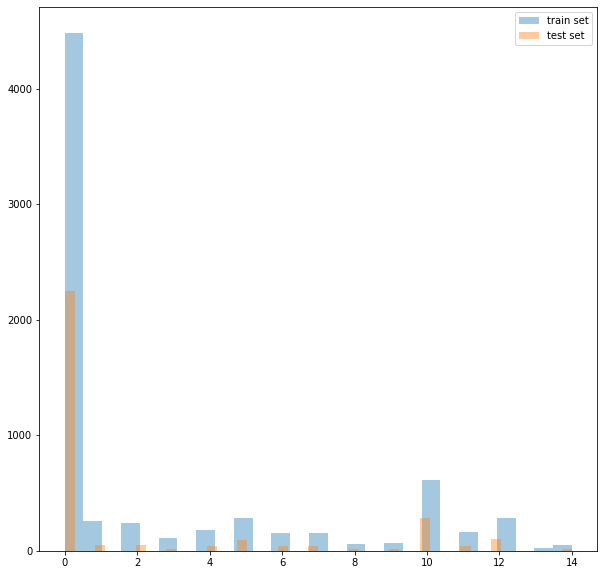

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
sns.distplot(final_train,kde=False,label = "train set",ax=ax)
sns.distplot(predictions,kde=False,label = "test set", ax=ax)
plt.legend()